In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [112]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [113]:
np.unique(np.array(trainset.targets),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [114]:
np.unique(np.array(testset.targets),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [115]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [60]:
# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_channels, out_channels, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)
#         self.shortcut = nn.Sequential()

#         if stride != 1 or in_channels != self.expansion * out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * out_channels)
#             )

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = self.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ResNet, self).__init__()
#         self.in_channels = 16
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU(inplace=True)
#         self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(128 * block.expansion, num_classes)

#     def _make_layer(self, block, out_channels, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_channels, out_channels, stride))
#             self.in_channels = out_channels * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avg_pool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def ResNet10():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

In [161]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        # self.in_channels = 16
        # self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(16)
        # self.relu = nn.ReLU(inplace=True)
        self.in_channels = 32
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc1 = nn.Linear(256 * block.expansion, 128*block.expansion)
        # self.fc2 = nn.Linear(128*block.expansion, 64*block.expansion)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        out = self.maxpool(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        # out = self.fc1(out)
        # out = self.relu(out)
        out = self.fc(out)
        return out

def ResNet10():
    return ResNet(BasicBlock, [3, 4, 4, 3])

In [162]:
model = ResNet10()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [163]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

4739498

In [164]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training hyperparameters
epochs = 100

for epoch in range(1, epochs + 1):
    train(model, device, trainloader, criterion, optimizer, epoch)
    test(model, device, testloader, criterion)
    scheduler.step()


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.634343
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.005864
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.680719
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.646539

Test set: Average loss: 0.0148, Accuracy: 4560/10000 (46%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.483505
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.461083
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.505484
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.292187

Test set: Average loss: 0.0135, Accuracy: 5091/10000 (51%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.372903
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.477375
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.239826
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.376918

Test set: Average loss: 0.0122, Accuracy: 5627/10000 (56%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.203738
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.213662
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.227664
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.212890

Test set: Average loss: 0.0115, Accu

In [160]:
torch.save(model,"model-32-inc-fc1-3443.pt")

In [165]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict1 = pickle.load(fo, encoding='bytes')
    return dict1
def model_test(model, data_path):
    dict = unpickle(data_path)
    data_test = dict[b'data']
    model.eval()
    pred = []
    images = torch.tensor(data_test,dtype=torch.float32)
    for i in images:
        output = model(i.reshape((-1, 3, 32, 32)).permute(0, 1, 2, 3).cuda())
        _, predicted = torch.max(output.data, 1)
        pred.extend(predicted.cpu().numpy())
    return pred

In [166]:
pred = model_test(model,"cifar_test_nolabels.pkl")
np.unique(pred, return_counts=True)

(array([1, 2, 8]), array([9600,   27,  373]))

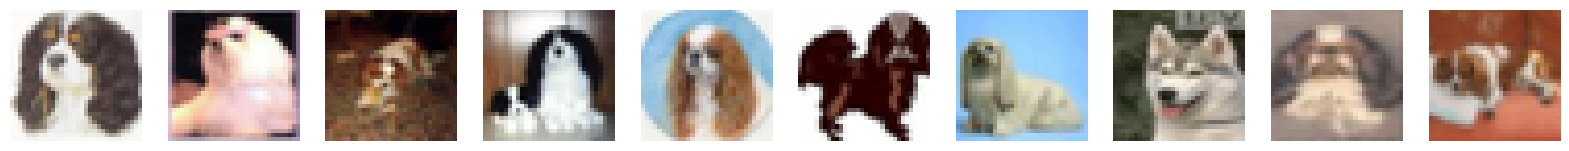

In [25]:
images = torch.tensor(data_test)
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).permute(0, 2, 3, 1)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(9000,9010):
    plt.subplot(1, 10, i+1-9000)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()